In [94]:
import camb
import pyccl as ccl
import numpy as np
import matplotlib
from scipy.stats import binned_statistic as bs
mpl = matplotlib
mpl.use('Agg') # Must be before importing matplotlib.pyplot
mpl.rcParams['font.size'] = 13.0
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.dpi'] = 200.0
mpl.rcParams['lines.markersize'] = 4.0
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 5.0
mpl.rcParams['xtick.minor.size'] = 3.0
mpl.rcParams['ytick.major.size'] = 5.0
mpl.rcParams['ytick.minor.size'] = 3.0
import matplotlib.pyplot
plt = matplotlib.pyplot
from astropy.table import Table
import GCR
from GCR import GCRQuery
import GCRCatalogs           


%matplotlib inline

In [78]:
def read_data(cat_name):
    '''note cat names: cosmoDC2_v1.1.4_small, buzzard_test, protoDC2'''
    cat = GCRCatalogs.load_catalog(cat_name, config_overwrite={'use_cache': False})
    data_quantities_wanted = ['magnification','ra','dec','mag_r_lsst','convergence','shear_1','shear_2','redshift']
    mag_z_cut_string = 'redshift < 1.0'
    query = GCRCatalogs.GCRQuery(mag_z_cut_string)
    all_data = cat.get_quantities(data_quantities_wanted, [query])
    all_data = Table(all_data)
    print(f'Loaded {len(all_data)} objects with {mag_z_cut_string} from the Object Table')
    return all_data

In [79]:
buzzard = read_data('buzzard_test')
cosmodc2 = read_data('cosmoDC2_v1.1.4_small')
protodc2 = read_data('protoDC2')

Loaded 8627627 objects with redshift < 1.0 from the Object Table
Loaded 40169301 objects with redshift < 1.0 from the Object Table
Loaded 18027539 objects with redshift < 1.0 from the Object Table


In [85]:
def create_mask(data,cat_name):
    mask_mag = (data['mag_r_lsst']<26)
    if cat_name=='buzzard_test':
        mask_mag = mask_mag&(data['ra']<20.) #some overflow from 360.
    return mask_mag

In [90]:
def make_bs_plot(data,cat_name):
    mask_mag = create_mask(data,cat_name)
    bn=500
    ra = data['ra'][mask_mag]
    dec = data['dec'][mask_mag]
    s1 = data['shear_1'][mask_mag]
    s2 = data['shear_2'][mask_mag]
    s1r ,redge, binn= bs(ra,s1,bins=bn, statistic='mean')
    s2r ,redge, binn= bs(ra,s2,bins=bn, statistic='mean')
    s1d ,dedge, binn= bs(dec,s1,bins=bn, statistic='mean')
    s2d ,dedge, binn= bs(dec,s2,bins=bn, statistic='mean')
    rvals = (redge[1:]+redge[:-1])/2.
    dvals = (dedge[1:]+dedge[:-1])/2.
    plt.figure()
    plt.title(cat_name)
    plt.plot(rvals,s1r,label='shear_1')
    plt.plot(rvals,s2r,label='shear_2')
    plt.plot(rvals,np.zeros(len(s1r)),'k--')
    plt.legend()
    plt.show()
    plt.figure()
    plt.title(cat_name)
    plt.plot(dvals,s1d,label='shear_1')
    plt.plot(dvals,s2d,label='shear_2')
    plt.plot(dvals,np.zeros(len(s1d)),'k--')
    plt.legend()
    plt.show()
    return 
    

In [104]:
def make_z_plot(data,cat_name):
    mask_mag = create_mask(data,cat_name)
    bn=500
    z = data['redshift'][mask_mag]
    s1 = data['shear_1'][mask_mag]
    s2 = data['shear_2'][mask_mag]
    s1z, zedge, binn = bs(z, s1, bins=bn, statistic='mean')
    s2z, zedge, binn = bs(z, s2, bins=bn, statistic = 'mean')
    zvals = (zedge[1:]+zedge[:-1])/2.
    plt.figure()
    plt.title(cat_name)
    plt.plot(zvals,s1z,label='shear_1')
    plt.plot(zvals,s2z,label='shear_2')
    plt.plot(zvals,np.zeros(len(s1z)),'k--')
    plt.legend()
    plt.show()
    return 

## Let's first investigate the variance of S1/S2 as a function of RA/Dec
The differences between these should be consistent between simulations, albeit these samples have different sky areas so the overall level of variance may differ. 
As you can see below, shear_2 is consistently smoother than shear_1 as a function of RA/Dec, even in the flat-sky protoDC2 catalog, because of the measurement direction. This appears reasonable.

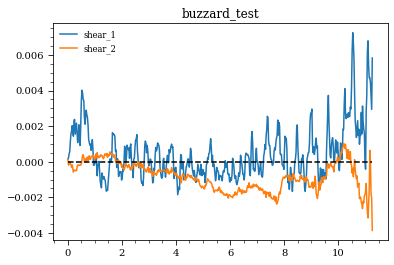

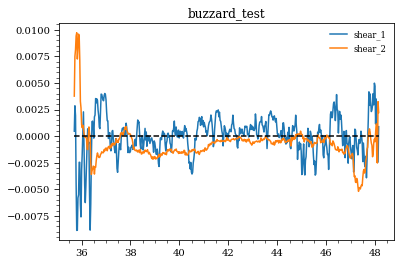

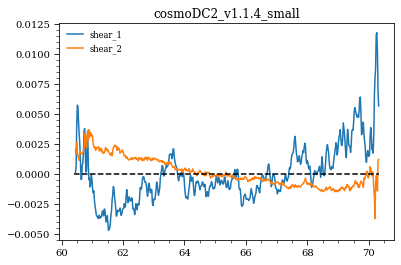

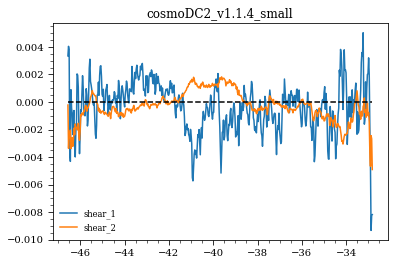

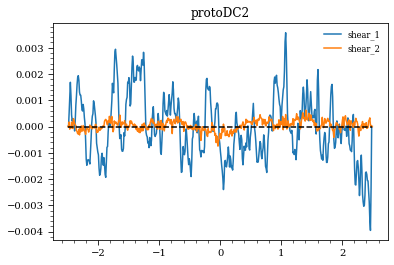

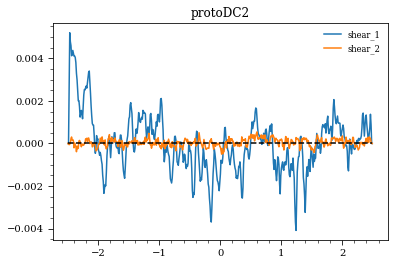

In [102]:
make_bs_plot(buzzard,'buzzard_test')
make_bs_plot(cosmodc2,'cosmoDC2_v1.1.4_small')
make_bs_plot(protodc2,'protoDC2')

## Variance of S1/S2 as a function of redshift

Now this is a bit more complicated. It is true that the protoDC2 catalog appears to have less of a redshift dependent variance than the larger-sky catalogs. However this is due to how the mean field is subtracted off. In protoDC2 the area is subtracted to enforce a zero average convergence. The larger catalogs are subsets of an area with the mean subtracted off either analytically or using the full area. 

You see some redshift dependent shear values in both buzzard and cosmoDC2. This redshift dependence is just a feature of the lensing. If this is due to some large filamentary structure you are effectively seeing the lensing kernel in the redshift dependence here, and the direction of the filament determines which of shear_1 or shear_2 are larger. To look into the level of this and see whether it is okay we need to look into the larger maps.

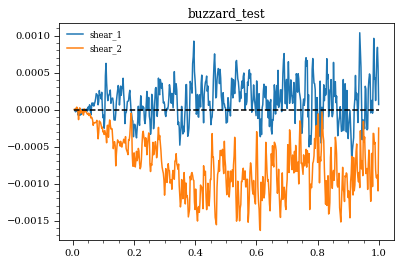

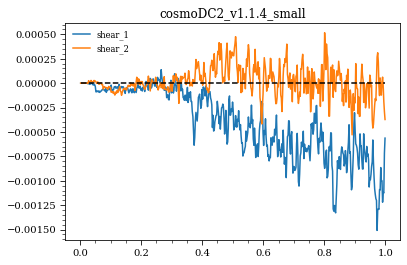

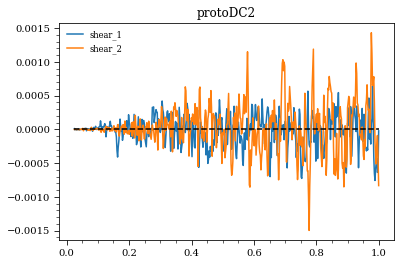

In [105]:
make_z_plot(buzzard,'buzzard_test')
make_z_plot(cosmodc2,'cosmoDC2_v1.1.4_small')
make_z_plot(protodc2,'protoDC2')